**关于该Notebook**

任务: 以沪深300数据集为例，使用scutquant包完成从原始数据到因子，再到拟合模型和回测的全过程。具体包括:  

(1)、使用**scutquant**(scutquant包下面的一个模块)和**alpha**构造目标值和因子，并自动完成特征工程和数据清洗(包括拆分数据集、填充和去除缺失值、标准化、截断异常值、重采样和降采样、特征筛选和正则化)  

(2)、使用**scutquant**一键建模(以lightgbm为例) 

(3)、使用**scutquant**的ic_ana计算IC、Rank IC和pearson相关系数等指标，并评价模型拟合情况(指标越高越好), IC的计算方式为  
 $$IC(t) = PearsonCorr(predict_{t}, y_{t})$$  
 其中, $PearsonCorr(x, y) = \frac{cov(x,y)}{\sqrt{\sigma_x * \sigma_y}}$, $predict_t$ 为t时刻所有资产的预测值序列(即截面上的预测值), 同理$y_t$ 为截面上的真实值
 
(4)、判断多因子在该模型下是否有效的t检验为 $t = ICIR * \sqrt{\Delta T}$, 其中$ICIR=\frac{\bar{IC}}{\sigma{IC}}$, $\Delta T$为时间间隔(例如测试集的天数). 该方法仅在IC分布为正态分布时成立(ic_ana会输出IC序列的分布图)  

(5)、使用**report**模块查看分组情况(按照每个time_tick的预测情况，对所有资产从高到低分成n组，并计算它们的累计平均收益率)。如果Group1到Group5呈现了明显的单调性(几条曲线交错很少, 且1~5由高到低呈现)则说明因子和模型的选股能力较强，因子较有效.  

5.1、其中, long-short为做多Group1(预测值最高)做空Group5(预测值最低)的累计收益，long-average为做多Group1并无差别做空资产池的累计收益(因为中国股市严格限制做空，因此long-short的收益难以实现，但是可以通过做空股指期货的做法实现套利, 而average对应的就是股指期货)，并给出预测的准确率($predict_{i,t}>=0$且$y_{i,t}>=0$或$predict_{i,t}<0$且$y_{i,t}<0$则为正确，否则为错误)  

(6)、使用**executor**模块执行回测, 需要在字典中写好策略和其它必要的参数, 并使用**report**模块报告回测结果  

In [1]:
# 导入需要用到的库
import pandas as pd
import scutquant.scutquant as q
from scutquant import alpha, report, executor

样例数据集只有基础的价量数据，以面板数据的形式呈现. 当需要额外数据构建因子时(例如需要构建市场因子Rm), 就需要读取supplemental data. 当补充数据为时序数据时，可以使用join_data函数将其合并到数据集中；当补充数据为各个股票的截面数据时，可以使用join_data_by_code按股票代码将数据合并到数据集中

In [2]:
# 读取数据
df = pd.read_csv("D:/Desktop/data.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df["mean_price"] = df["amount"] / df["vol"] * 10  # 每支股票在当天的交易均价
df.set_index(["datetime", "ts_code"], inplace=True)
df.index.names = ["datetime", "instrument"]
df

open    high     low   close  pre_close  change  \
datetime   instrument                                                      
2006-01-04 000001.SZ     6.13    6.33    6.12    6.28       6.14    0.14   
           000002.SZ     4.40    4.67    4.40    4.66       4.31    0.35   
           000012.SZ     4.70    4.75    4.55    4.70       4.62    0.08   
           000016.SZ     3.52    3.58    3.52    3.57       3.52    0.05   
           000021.SZ     7.99    8.40    7.99    8.32       8.00    0.32   
...                       ...     ...     ...     ...        ...     ...   
2022-12-30 688363.SH   136.00  137.00  131.50  135.28     135.49   -0.21   
           688396.SH    53.06   53.40   52.49   52.65      52.87   -0.22   
           688561.SH    65.49   67.88   64.85   65.77      65.46    0.31   
           688599.SH    63.31   64.56   62.31   63.76      63.20    0.56   
           688981.SH    41.01   41.35   41.01   41.14      40.89    0.25   

                       pct_chg        vol       amount  mean_price  
datetime   instrument                                               
2006-01-04 000001.SZ    2.2800  154450.68   96989.0066    6.279610  
           000002.SZ    8.1200  389310.43  175187.0657    4.499933  
           000012.SZ    1.7300   40399.61   18863.8625    4.669318  
           000016.SZ    1.4200   14426.65    5131.8793    3.557222  
           000021.SZ    4.0000   33526.60   27657.1708    8.249322  
...                        ...        ...          ...         ...  
2022-12-30 688363.SH   -0.1550   29951.60  401624.1560  134.091052  
           688396.SH   -0.4161   23401.54  123568.2880   52.803486  
           688561.SH    0.4736   22567.89  149379.0770   66.190981  
           688599.SH    0.8861  109144.36  695759.9350   63.746760  
           688981.SH    0.6114   60396.11  248594.8820   41.160744  

[1199445 rows x 10 columns]

**关于目标值:** 为了避免数据泄露和其它各种问题，我们构建的目标值应尽量与已知数据无关(即$y_t$无法用已知的数据${X_t, X_{t-1}, ...}$计算得到). 这里我们选择$label = \frac{close_{-2}}{close_{-1}} - 1$, 即T时刻需要预测的目标值是T+2相对于T+1的收益率, 现实意义是在今天(T)作出预测, 并在明天(T+1)以收盘价开仓, 后天(T+2)以收盘价平仓  

**关于因子:** 参考alpha模块中的make_factors()和alpha360(), 前者主要为技术指标, 后者是原始量价数据的滞后项除单位, 目的是让模型在张成的360维空间中自行发掘因子

In [3]:
# 构造目标值
df["label"] = df["pct_chg"].groupby("instrument").shift(-2) / 100
df = df.dropna() 

In [4]:
kwargs = {
    "data": df,
    "open": "open",
    "close": "close",
    "high": "high",
    "low": "low",
    "volume": "vol",
    "amount": "amount",
}
X = alpha.make_factors(kwargs=kwargs)
X = pd.concat([X, df[["label"]]], axis=1)
X = X.dropna()

time used: 178.98519086837769


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1144841 entries, (Timestamp('2006-04-07 00:00:00'), '000001.SZ') to (Timestamp('2022-12-28 00:00:00'), '688981.SH')
Columns: 177 entries, RET1_1 to label
dtypes: float64(177)
memory usage: 1.5+ GB
None
X_mis= 0.0
clean dataset done 

split data done 

label norm done 

The distribution of y_train:


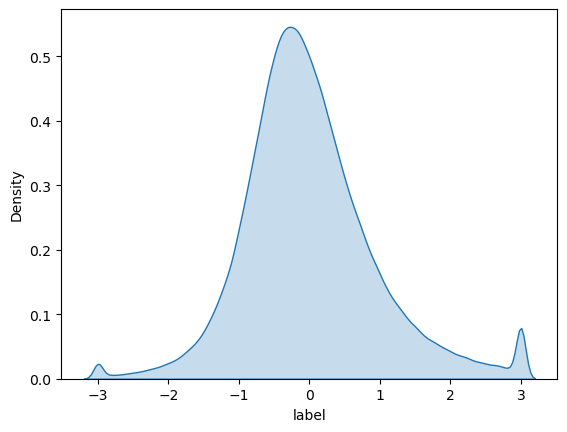

The distribution of y_valid:


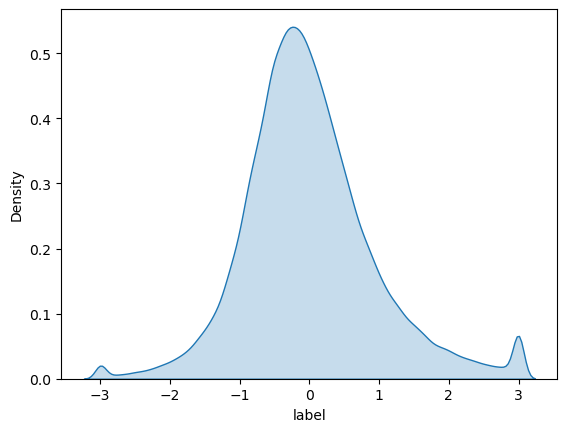

The distribution of y_test:


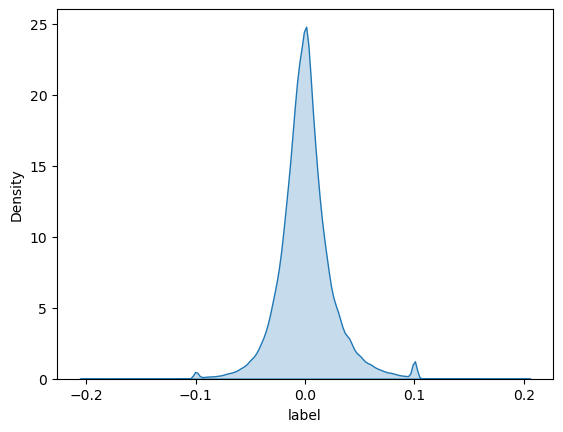

norm data done 

all works done 



In [5]:
split_params = {
    "test_start_date": "2019-01-01",
    "split_method": "group_split",
    "split_kwargs":{
        "train": 0.7,
        "valid": 0.3
    }
}
# 按split_params拆分出训练集、验证集和测试集, 并在截面上进行标准化
result = q.auto_process(X, "label", groupby="instrument", split_params=split_params, select=False, orth=False, clip=5)

X_train, y_train, X_valid, y_valid = result["X_train"], result["y_train"], result["X_valid"], result["y_valid"]
X_test, y_test, ymean, ystd = result["X_test"], result["y_test"], result["ymean"], result["ystd"]

对选定的因子进行中性化(目前版本对内存的要求很高, 但有时候确实能带来一些提升)

In [6]:
#X_train = alpha.neutralize(X_train, df["amount"], features=X_train.columns[0: 20])
#X_valid = alpha.neutralize(X_valid, df["amount"], features=X_train.columns[0: 20])
#X_test = alpha.neutralize(X_test, df["amount"], features=X_train.columns[0: 20])
#X_train

In [7]:
# 查看数据处理的结果
X_train.describe()

,RET1_1,RET2_1,RET1_2,RET2_2,RET1_3,RET2_3,RET1_4,RET2_4,SHARPE5,SHARPE10,...,MEAN2_5,MEAN2_10,MEAN2_20,MEAN2_30,MEAN2_60,AMOUNT5,AMOUNT10,AMOUNT20,AMOUNT30,AMOUNT60
count,604469.000000,6.044690e+05,604469.000000,6.044690e+05,604469.000000,6.044690e+05,604469.000000,6.044690e+05,6.044690e+05,6.044690e+05,...,604469.000000,604469.000000,604469.000000,604469.000000,604469.000000,604469.000000,604469.000000,604469.000000,604469.000000,604469.000000
mean,0.002964,4.234676e-18,0.003487,4.477119e-18,0.003223,1.375315e-18,0.002784,9.201089e-18,4.452140e-18,8.727958e-19,...,-0.009607,-0.009779,-0.008883,-0.008238,-0.006473,-0.007079,-0.008336,-0.009468,-0.010177,-0.010828
std,0.954628,9.982042e-01,0.947428,9.982042e-01,0.946380,9.982042e-01,0.947897,9.982042e-01,9.982042e-01,9.982042e-01,...,0.908962,0.915202,0.928007,0.935660,0.951678,0.939071,0.930216,0.922613,0.917119,0.913314
min,-5.000000,-1.842963e+00,-5.000000,-1.861898e+00,-5.000000,-1.974980e+00,-5.000000,-1.939136e+00,-1.895748e+00,-2.031546e+00,...,-5.000000,-5.000000,-5.000000,-5.000000,-5.000000,-3.041176,-2.591190,-2.352339,-2.081704,-1.824824
25%,-0.537780,-8.636641e-01,-0.522655,-8.634970e-01,-0.515622,-8.633904e-01,-0.515129,-8.630407e-01,-8.641154e-01,-8.637333e-01,...,-0.444411,-0.462152,-0.488087,-0.504097,-0.529827,-0.601103,-0.593730,-0.589634,-0.582959,-0.574487
50%,-0.085448,0.000000e+00,-0.068251,0.000000e+00,-0.067215,0.000000e+00,-0.067641,0.000000e+00,0.000000e+00,0.000000e+00,...,0.004775,-0.012337,-0.039393,-0.056046,-0.083914,-0.157680,-0.173945,-0.195589,-0.206278,-0.222604
75%,0.439259,8.638840e-01,0.443636,8.639920e-01,0.442940,8.635477e-01,0.444618,8.640094e-01,8.644940e-01,8.644940e-01,...,0.447363,0.436685,0.424359,0.416044,0.406830,0.359496,0.330364,0.304802,0.279874,0.257423
max,5.000000,1.926434e+00,5.000000,1.863900e+00,5.000000,1.966210e+00,5.000000,1.914478e+00,1.926611e+00,1.875965e+00,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [8]:
# 拟合模型
model = q.auto_lgbm(X_train, y_train, X_valid, y_valid, early_stopping=50)

pred = model.predict(X_test)
pred = pd.DataFrame(pred, columns=["predict"], index=X_test.index)
pred["predict"] += ymean.groupby("datetime").shift(2).fillna(0.0002)  # 为防止数据泄露, 使用滞后2阶的mean和std还原预测值
pred["predict"] *= ystd.groupby("datetime").shift(2).fillna(0.0189)
pred.describe()

Training until validation scores don't improve for 50 rounds
[20]	train's l2: 0.878808	valid's l2: 0.883479
[40]	train's l2: 0.876019	valid's l2: 0.882441
[60]	train's l2: 0.874	valid's l2: 0.881858
[80]	train's l2: 0.87224	valid's l2: 0.881421
[100]	train's l2: 0.870728	valid's l2: 0.881065
[120]	train's l2: 0.869287	valid's l2: 0.880838
[140]	train's l2: 0.868002	valid's l2: 0.880653
[160]	train's l2: 0.866667	valid's l2: 0.880506
[180]	train's l2: 0.865564	valid's l2: 0.880349
[200]	train's l2: 0.864341	valid's l2: 0.880264
[220]	train's l2: 0.863095	valid's l2: 0.880139
[240]	train's l2: 0.861977	valid's l2: 0.880037
[260]	train's l2: 0.860902	valid's l2: 0.879982
[280]	train's l2: 0.859738	valid's l2: 0.879919
[300]	train's l2: 0.858587	valid's l2: 0.879913
[320]	train's l2: 0.857528	valid's l2: 0.879869
[340]	train's l2: 0.856525	valid's l2: 0.879868
[360]	train's l2: 0.855498	valid's l2: 0.879887
Early stopping, best iteration is:
[322]	train's l2: 0.857413	valid's l2: 0.879863


,predict
count,281836.000000
mean,-0.000183
std,0.001589
min,-0.014443
25%,-0.001116
50%,-0.000194
75%,0.000750
max,0.008900


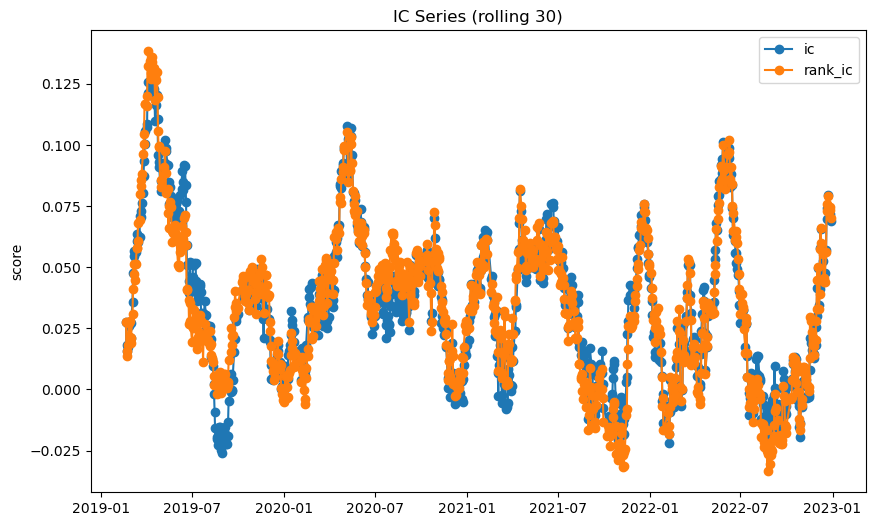

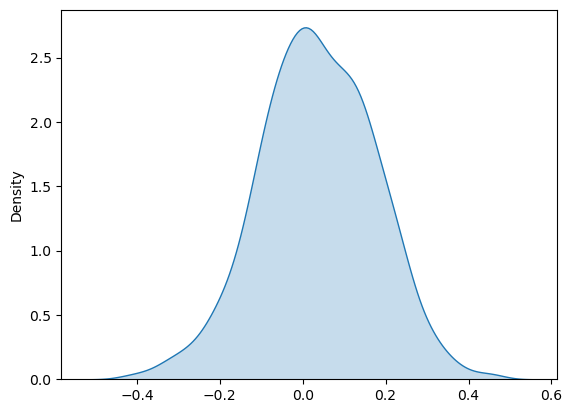

ic= 0.03419250302225847 icir= 0.24528820258623987 rank_ic= 0.034120868042435505 rank_icir= 0.23884706606203246


0.03076131510009579

In [9]:
# 使用IC评判拟合优度
ic, icir, rank_ic, rank_icir = q.ic_ana(pred, y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)
# 使用pearson相关系数评判拟合优度
r = q.pearson_corr(pred["predict"], y_test)
r

In [10]:
# 以下为回测部分
# 将预测值处理成回测需要的格式(需要知道预测值"predict", 交易价格price和交易量volume)
df_test = df[df.index.get_level_values(0) >= "2019-01-01"]
pred = executor.prepare(pred, df_test, price='mean_price', volume='vol', real_ret=y_test)

Accuracy of Prediction: 0.5283280380408129


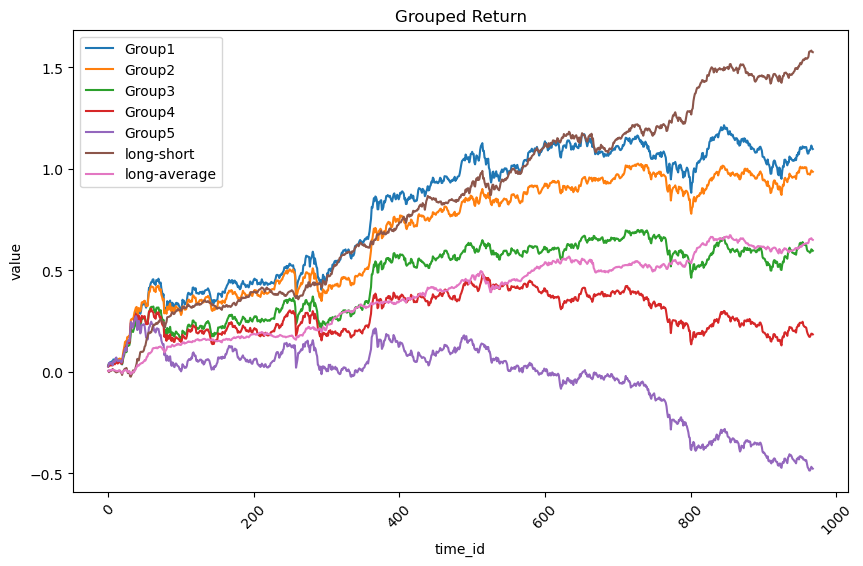

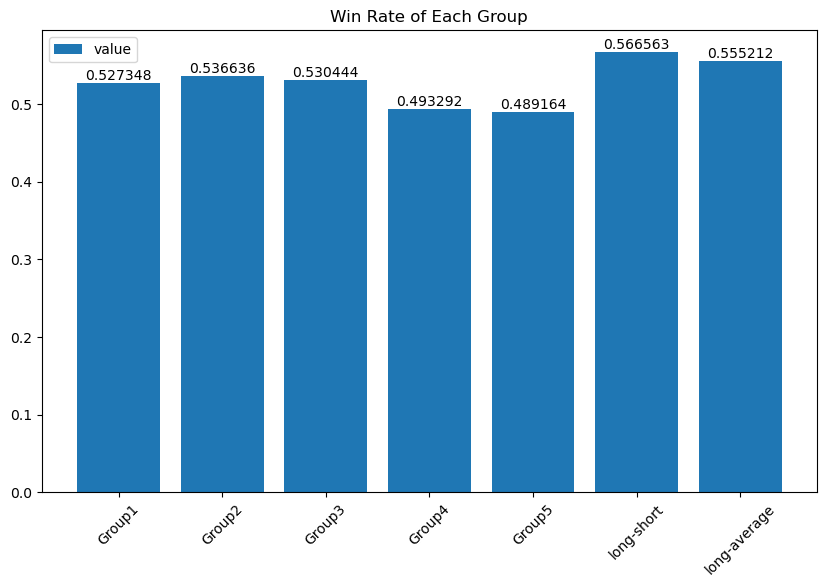

In [11]:
# 如果出现明显的分层, 则说明因子有良好的选股能力
report.group_return_ana(pred, y_test)

目前测得的策略容量以1亿(或者更少)为佳

In [12]:
backtest = {
    "generator": {
        "mode": "generate"
    },
    "strategy": {
        "class": "TopKStrategy",  # 做多预测值前20%股票, 做空后20%的股票. 自动平仓
        "kwargs": {
            "k": 0.2,
            "auto_offset": False,
            "offset_freq": 2, # 应为delta_t + 1, 例如目标值是close_-2 / close_-1 - 1, 则delta_t = 1
            "buy_only": False,  # =True时，只做多不做空(在A股做空有一定的难度)
            "short_volume": 500, # 融券做空的数量
            "risk_degree": 0.95,  # 将风险度控制在这个数，如果超过了就按比例减持股票直到风险度小于等于它为止
            "unit": None,  # 由于数据已经是以手为单位, 故无需二次处理
            "max_volume": 0.05  # 手数随可用资金而改变，最大不会超过股票当天成交量的1%(例如T+1时下单，下单手数不会超过T时成交量的1%)
        }
    },
    "account": None, # 使用默认账户, 即初始资金为1亿, 无底仓 (注意策略容量！)
    "trade_params": {
        "cost_buy": 0.0015,  # 佣金加上印花税
        "cost_sell": 0.0015,  
        "min_cost": 5,
    }
}
generator, strategy, account, trade_params = backtest["generator"], backtest["strategy"], backtest["account"], backtest["trade_params"]
exe = executor.Executor(generator, strategy, account, trade_params)
exe.execute(data=pred, verbose=0)  # verbose=1时，按时间输出买卖指令

Annualized Return: 0.1493109663338692
Annualized Volatility: 0.12396882323182011
Annualized Return(Benchmark): 0.09295809982780767
Annualized Volatility(Benchmark): 0.09328578277151958 

Cumulative Rate of Return: 0.7076417802947588
Cumulative Rate of Return(Benchmark): 0.4074717885488688
Cumulative Excess Rate of Return: 0.30016999174589 

Max Drawdown: -0.23167551931357885
Max Drawdown(Benchmark): -0.26422721795656307
Max Drawdown(Excess Return): -0.13146349532919704 

Sharpe Ratio: 2.294005159423302
Sortino Ratio: 1.0679644518815568
Information Ratio: 0.5014338796934026 

Beta: 1.2651811815997114
Alpha: 0.006317856616220752
Epsilon: 0.07437947518172185
Profitable Days(%): 0.9195046439628483


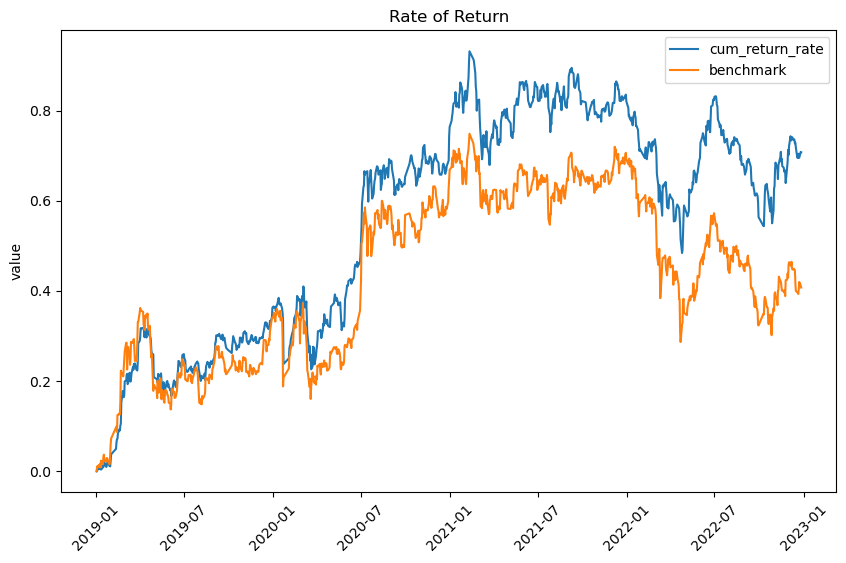

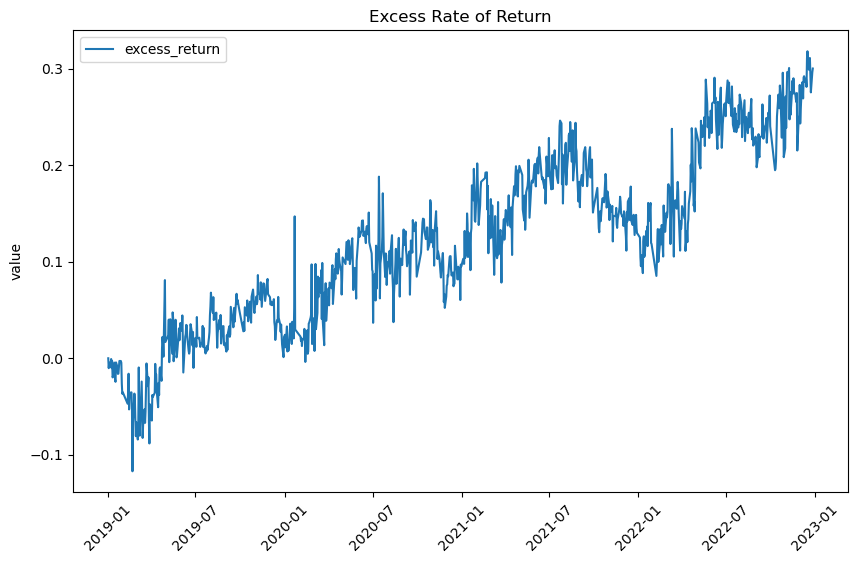

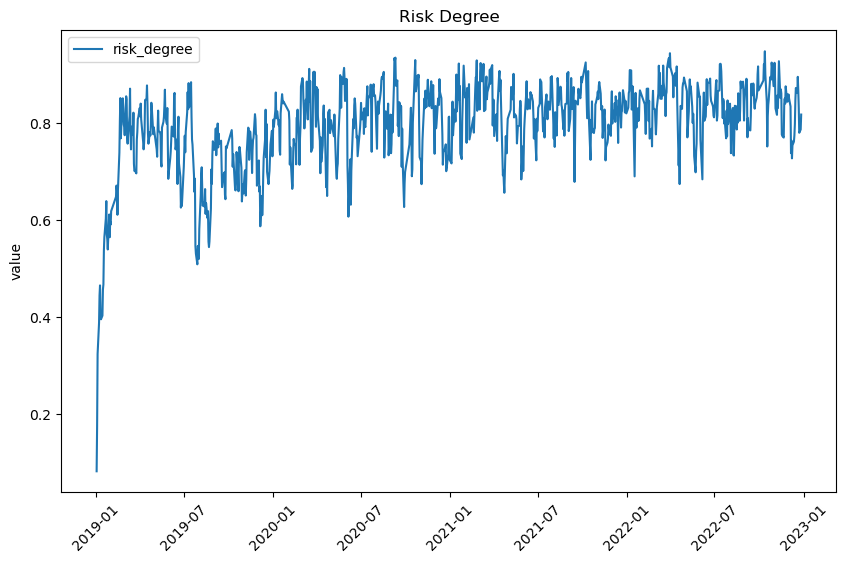

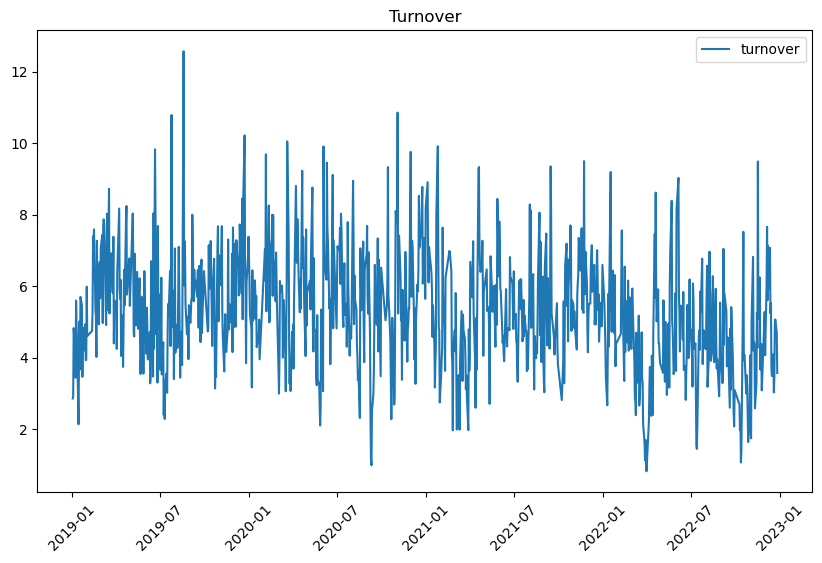

In [13]:
# 报告回测结果
user_account, benchmark = exe.user_account, exe.benchmark
report.report_all(user_account, benchmark, freq=1, time=exe.time)  # 无风险收益率默认为年化3%，可以通过参数rf调节

In [14]:
# user_account.buy_hist # 查看历史上所有买单